In [1]:
!nvidia-smi

Fri Jul 25 23:55:45 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.88                 Driver Version: 576.88         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   66C    P0             27W /   60W |     283MiB /   4096MiB |     44%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install torch torchvision transformers roboflow

In [3]:
from roboflow import Roboflow

rf = Roboflow(api_key="SklUvw2qusJaogyNJDNM")  # replace with your API key
project = rf.workspace("tugas-akhir-icad").project("proyek-akhir-icad")
version = project.version(12)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...


In [4]:
# Download dataset from Roboflow Universe
userdata = {
    'ROBOFLOW_API_KEY': 'SklUvw2qusJaogyNJDNM'
}
ROBOFLOW_API_KEY = userdata.get('ROBOFLOW_API_KEY')
rf = Roboflow(api_key=ROBOFLOW_API_KEY)

project = rf.workspace("tugas-akhir-icad").project("proyek-akhir-icad")
version = project.version(12)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...


In [5]:
# CBAM Module Implementation

import torch
import torch.nn as nn

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super().__init__()
        self.shared = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )

    def forward(self, x):
        avg_out = self.shared(x)
        max_out = self.shared(x)
        return x * torch.sigmoid(avg_out + max_out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super().__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2, bias=False)

    def forward(self, x):
        avg = torch.mean(x, dim=1, keepdim=True)
        max_, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg, max_], dim=1)
        return x * torch.sigmoid(self.conv(x_cat))

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super().__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        x = self.ca(x)
        x = self.sa(x)
        return x

In [6]:
# YOLO Block with CBAM
class ConvCBAMBlock(nn.Module):
    def __init__(self, in_channels, out_channels, use_cbam=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU(inplace=True)
        self.use_cbam = use_cbam
        self.cbam = CBAM(out_channels) if use_cbam else nn.Identity()

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        x = self.cbam(x)
        return x

In [7]:
# YOLOv12 backbone with CBAM
class YOLOv12Backbone(nn.Module):
    def __init__(self, use_cbam=True):
        super().__init__()
        self.block1 = ConvCBAMBlock(3, 64, use_cbam)
        self.block2 = ConvCBAMBlock(64, 128, use_cbam)
        self.block3 = ConvCBAMBlock(128, 256, use_cbam)
        self.block4 = ConvCBAMBlock(256, 512, use_cbam)

    def forward(self, x):
        x = self.block1(x)
        x = nn.MaxPool2d(2)(x)
        x = self.block2(x)
        x = nn.MaxPool2d(2)(x)
        x = self.block3(x)
        x = nn.MaxPool2d(2)(x)
        x = self.block4(x)
        return x

In [8]:
class YOLOv12Head(nn.Module):
    def __init__(self, in_channels, num_classes, num_anchors=3):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, num_anchors * (num_classes + 5), kernel_size=1)

    def forward(self, x):
        # Example output shape: [B, anchors*(5+num_classes), H, W]
        return self.conv(x)

In [9]:
class YOLOv12_CBAM(nn.Module):
    def __init__(self, num_classes=7, use_cbam=True):
        super().__init__()
        self.backbone = YOLOv12Backbone(use_cbam=use_cbam)
        self.head = YOLOv12Head(in_channels=512, num_classes=num_classes)

    def forward(self, x):
        feats = self.backbone(x)
        return self.head(feats)

# WA

In [ ]:
#pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121Note: you may need to restart the kernel to use updated packages.

  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp310-cp310-win_amd64.whl (4.1 MB)
INFO: pip is looking at multiple versions of torchaudio to determine which version is compatible with other requirements. This could take a while.
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.5.0%2Bcu121-cp310-cp310-win_amd64.whl (4.1 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.4.1%2Bcu121-cp310-cp310-win_amd64.whl (4.1 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.4.0%2Bcu121-cp310-cp310-win_amd64.whl (4.1 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.3.1%2Bcu121-cp310-cp310-win_amd64.whl (4.1 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.3.0%2Bcu121-cp310-cp310-win_amd64.whl (4.1 MB)
  Using cached https://download.pytorch.org/

  You can safely remove it manually.


     ----------------------------- ---------- 1.8/2.4 GB 10.9 MB/s eta 0:00:59
     ----------------------------- ---------- 1.8/2.4 GB 10.9 MB/s eta 0:00:59
     ----------------------------- ---------- 1.8/2.4 GB 10.9 MB/s eta 0:00:59
     ----------------------------- ---------- 1.8/2.4 GB 10.9 MB/s eta 0:00:58
     ----------------------------- ---------- 1.8/2.4 GB 10.9 MB/s eta 0:00:58
     ----------------------------- ---------- 1.8/2.4 GB 10.9 MB/s eta 0:00:58
     ----------------------------- ---------- 1.8/2.4 GB 10.9 MB/s eta 0:00:58
     ----------------------------- ---------- 1.8/2.4 GB 11.0 MB/s eta 0:00:57
     ----------------------------- ---------- 1.8/2.4 GB 11.0 MB/s eta 0:00:57
     ----------------------------- ---------- 1.8/2.4 GB 11.0 MB/s eta 0:00:56
     ------------------------------ --------- 1.8/2.4 GB 11.0 MB/s eta 0:00:56
     ------------------------------ --------- 1.8/2.4 GB 11.0 MB/s eta 0:00:56
     ------------------------------ --------- 1.8/2.

In [10]:
import torch
print(torch.cuda.is_available()) 

True


In [11]:
!pip install pycocotools

In [12]:
from pycocotools.coco import COCO
from torch.utils.data import Dataset
import os
from PIL import Image

class CocoDataset(Dataset):
    def __init__(self, img_dir, ann_path, transform=None):
        self.coco = COCO(ann_path)
        self.img_dir = img_dir
        self.ids = list(self.coco.imgs.keys())
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, index):
        img_id = self.ids[index]
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        img_info = self.coco.loadImgs(img_id)[0]
        path = os.path.join(self.img_dir, img_info['file_name'])
        image = Image.open(path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        targets = []
        for ann in anns:
            bbox = ann['bbox']  # [x, y, width, height]
            category = ann['category_id']
            targets.append((bbox, category))

        return image, targets

In [13]:
# Dataloader
from torchvision import transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

train_dataset = CocoDataset(
    img_dir=f"proyek-akhir-icad-12/train",
    ann_path=f"proyek-akhir-icad-12/train/_annotations.coco.json",
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


In [14]:
model = YOLOv12_CBAM(num_classes=7).cuda()

In [16]:
import json
with open(f"proyek-akhir-icad-12/train/_annotations.coco.json") as f:
    coco = json.load(f)
num_classes = len(coco["categories"])

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

train_losses = []
val_losses = []

for epoch in range(10):
    model.train()
    for imgs, targets in train_loader:
        imgs = torch.stack(imgs).cuda()
        # You’ll need to convert `targets` into your model's required format (YOLO targets)
        optimizer.zero_grad()
        preds = model(imgs)
        loss = preds.mean()  # Replace with proper YOLO loss computation
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}: Loss {loss.item():.4f}")
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

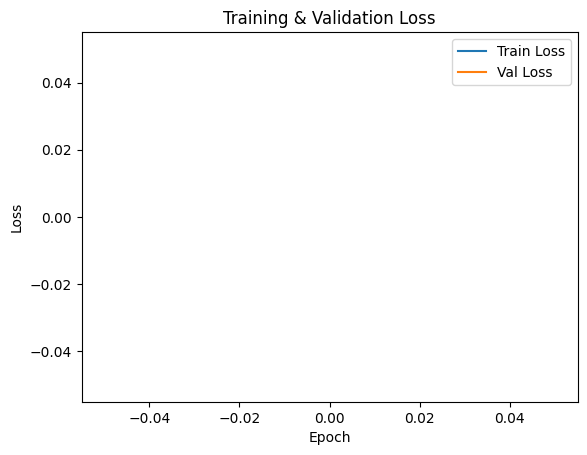

In [ ]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []

# After each epoch (in your loop):
train_losses.append(avg_train_loss)
val_losses.append(avg_val_loss)

# After training:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()

In [20]:
model.eval()
with torch.no_grad():
    for imgs, _ in test_loader:  # or val_loader
        imgs = torch.stack(imgs).cuda()
        preds = model(imgs)  # your model's forward pass

        # Postprocess and visualize predictions
        for img, pred in zip(imgs, preds):
            # Assuming pred includes boxes, scores, and labels
            draw_prediction(img, pred)
        break  # just show one batch

NameError: name 'test_loader' is not defined

In [ ]:
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import cv2

def draw_prediction(img_tensor, pred):
    img_np = F.to_pil_image(img_tensor.cpu())
    img_np = np.array(img_np)

    for box, score, label in zip(pred['boxes'], pred['scores'], pred['labels']):
        if score > 0.5:
            x1, y1, x2, y2 = box.int().tolist()
            cv2.rectangle(img_np, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(img_np, f'{label}:{score:.2f}', (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1)

    plt.imshow(img_np)
    plt.axis('off')
    plt.show()